# TensorFlow: Function Approximation Example 2 (Multi-Layer Perceptron)

_This example was originally written for the Practical Machine Learning Summer School developed by Adrian Bevan (a.j.bevan@qmul.ac.uk) for Queen Mary University of London (C) 2020 and has been modified for the RAL Machine Learning Tutorial (May 2020)._

This is an example for using TensorFlow machine learning.  A single layer perceptron is used to learn the function $y = x^2$.  This jupyter notebook uses an L2 loss function and allows the user to specify some range $x \in [min\_x, max\_x]$ for plotting.  Test and train samples of events will be created and the network will be trained and evaluated as a function of training epoch.

The purpose is to illustrate the application of a neural network to learning y=f(x) with a single dimensional input feature space resulting in a regression output for a single dimensional output feature space.  The network has a specified number of nodes, each uses a Rectified Linear Unit (ReLU) activation function.  This activation function is given by 

 $f = \max(0, w x) + b$

where $w$ is the weight and $b$ the bias parameter.  The neural network configuration is for a multilayer perceptron, set up with one input, 2 layers of 50 nodes and one output.  

We will use three Python libraries for this example: numpy, tensorflow and matplotlib.  In addition to the network weights (also known as model hyperparmeters) we have the following hyperparameters related to the optimisation of the network:

 * __learning_rate__ - this is the step size for the gradient descent optimisation process that is used (we will use the ADAM optimiser for this example).  The smaller the step size the longer it will take for the optimisation process to converge. The larger the step size the quicker to converge - up to a point.  The gradient descent algorothm is derived assuming that the step size is sufficiently small so as to guarantee a reduction inthe rate.  Try changing this parameter by a factor of 10 or more in either direction (so down to 0.001 and up to 0.1) to see what happens.
 * __training_epochs__ - this is the number of gradient descent optimisation steps taken.  
 
 Other parameter related to the problem include the range parameters (noted above) initially set to $[min\_x, max\_x] = [-10, 10]$ and Ngen, the number of training examples to generate.
 

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()

print("Using the following TensorFlow version:")
print(tf.__version__)
# Network training parameters
learning_rate    = 0.001
training_epochs  = 1000
min_x = -10
max_x = 10
Ngen  = 10000

# Network architecture parameters
n_input        = 1   # 1D function, so there is one input feature per example
n_classes      = 1   # Regression output is single valued
n_nodes_layer1 = 50  # 1st layer num features
n_nodes_layer2 = 50  # 2nd layer num features
noise          = 0.1 # add a noise term to simulate fluctuations in the data

print("--------------------------------------------")
print("Number of input features       = ", n_input)
print("Number of output classes       = ", n_classes)
print("Number of examples to generate = ", Ngen)
print("Learning rate            alpha = ", learning_rate)
print("Number of training epochs      = ", training_epochs)
print("--------------------------------------------")

Using the following TensorFlow version:
2.2.0
--------------------------------------------
Number of input features       =  1
Number of output classes       =  1
Number of examples to generate =  10000
Learning rate            alpha =  0.001
Number of training epochs      =  1000
--------------------------------------------


The following cell sets up the graph to be evaluated. There are several parts to this cell:

* The  Python function myFunctionTF defines the function that will be approximated. The argument type is a numpy array; and so the function converts the input feature (x) into the output feature (target) value (y).
* Specify the placeholders x and y that will be used to feed data into the evaluation steps (optimisation, loss function and model prediction)
* Construct the model - this is a single layer neural network consisting of 1 input, 50 nodes with a relu activation function and a single output constructed from the previous layer.
* Use the L2 loss function (computed in a different way to the previous example) and the ADAM optimiser (see the notes on neural networks for this gradient descent algorithm.
* Finally we set up the test and training data (we want to have statistically independent samples to work with for this example to study the training performance).

In [9]:

def myFunctionTF(arg):
    """
    User defined function for the MLP to learn.  The default example is 
    the square function.  We also add noise to the data.
    
    Note that random_normal is deprecated in more recent TF APIs. See the 
    website for information.
    """
    return myFunctionTF_true(arg)+noise*tf.random.normal([Ngen, 1])

def myFunctionTF_true(arg):
    """
    User defined function for the MLP to learn.  The default example is 
    the square function.
    """
    return tf.square(arg)


# tf Graph input:
#  x: is the tensor for the input data (the placeholder entry None is used for that;
#     and the number of features input (n_input = 1).
#
#  y: is the tensor for the output value of the function that is being approximated by 
#     the MLP.
#
x = tf.compat.v1.placeholder(tf.float32, [None, n_input], name="x")
y = tf.compat.v1.placeholder(tf.float32, [None, n_classes], name="y")


# We construct layer 1 from a weight set, a bias set and the activiation function used
# to process the impulse set of features for a given example in order to produce a 
# predictive output for that example.
#
#  w_layer_1:    the weights for layer 1.  The first index is the input feature (pixel)
#                and the second index is the node index for the perceptron in the first
#                layer.
#  bias_layer_1: the biases for layer 1.  There is a single bias for each node in the 
#                layer.
#  layer_1:      the activation functions for layer 1
#
print("Creating a hidden layer with ", n_nodes_layer1, " nodes")
w_layer_1    = tf.Variable(tf.random.normal([n_input, n_nodes_layer1]), name="weights_layer_1")
bias_layer_1 = tf.Variable(tf.random.normal([n_nodes_layer1]), name="bias_layer_1")
layer_1      = tf.nn.relu(tf.add(tf.matmul(x,w_layer_1),bias_layer_1))

# repeat for layer 2
print("Creating a hidden layer with ", n_nodes_layer2, " nodes")
w_layer_2    = tf.Variable(tf.random.normal([n_nodes_layer1, n_nodes_layer2]), name="weights_layer_2")
bias_layer_2 = tf.Variable(tf.random.normal([n_nodes_layer2]), name="bias_layer_2")
layer_2      = tf.nn.relu(tf.add(tf.matmul(layer_1,w_layer_2),bias_layer_2))

# Similarly we now construct the output of the network, where the output layer
# combines the information down into a space of evidences for the possible
# classes in the problem (n_classes=1 for this regression problem).
print("Creating the output layer ", n_classes, " output values")
output       = tf.Variable(tf.random.normal([n_nodes_layer2, n_classes]), name="weights_output")
bias_output  = tf.Variable(tf.random.normal([n_classes]), name="bias_output")
output_layer = tf.matmul(layer_2, output) + bias_output

#optimise with l2 loss function
print("Using the L2 loss function implemented in tf.nn")
loss = tf.nn.l2_loss(y - output_layer)

# optimizer: take the Adam optimiser, see https://arxiv.org/pdf/1412.6980v8.pdf for
# details of this algorithm.
print("Using the Adam optimiser to train the network")
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# generate data, the input data is a random number betwen 1 and 10,
# and the corresponding label value is the square root of that number
print("Generating the test and training sets.  There are ", Ngen, " examples in each")
tftraindata = tf.random.uniform([Ngen, 1], min_x, max_x)  # training set
tftestdata  = tf.random.uniform([Ngen, 1], min_x, max_x)  # test set


# define operation for computing the regression output
probabilities = output_layer

# Initializing the variables
init  = tf.compat.v1.global_variables_initializer()

# Start the session to embark on the training cycle
sess = tf.compat.v1.Session()
sess.run(init)

# convert the training data to np arrays so that these can be used with the feed_dict when training
traindata  = sess.run(tftraindata) 
target_value = sess.run(myFunctionTF(traindata))

# convert the test data to np arrays so that these can be used with the feed_dict when training and evaluating model performance
testdata  = sess.run(tftestdata) 
test_value = sess.run(myFunctionTF(testdata))
true_value = sess.run(myFunctionTF_true(testdata))



Creating a hidden layer with  50  nodes
Creating a hidden layer with  50  nodes
Creating the output layer  1  output values
Using the L2 loss function implemented in tf.nn
Using the Adam optimiser to train the network
Generating the test and training sets.  There are  10000  examples in each


The following cell will evaluate the model graph for the specified number of epochs.  

For the last epoch we will use the model to make predictions over the range that the model was trained on, so that we can compare this to the input training data.

In [10]:
# arrays to compare the input value vs the prediction
input_value      = []
epoch_set        = []
loss_test_value  = []
loss_set         = []
prediction_value = []

print("Will run through ", training_epochs, " training epochs")
# Training cycle - for this example we do not batch train as this is a shallow network with 
# a low number of training events.
for epoch in range(training_epochs):
    the_loss = 0.
    
    if not (epoch % 500):
        print("  Training epoch number ", epoch)
    sess.run(optimizer, feed_dict={x: traindata, y: target_value})
    the_loss = sess.run(loss, feed_dict={x: traindata, y: target_value})

    loss_set.append(the_loss)
    epoch_set.append(epoch+1)
    
    the_loss = sess.run(loss, feed_dict={x: testdata, y: test_value})
    loss_test_value.append(the_loss)

    #
    # This is a regression analysis problem, so we want to evaluate and display the output_layer
    # value (model response function), and not an output prediction (which would have been appropraite
    # for a classification problem)
    #
    if epoch == training_epochs-1:
        step = (max_x - min_x)/100
        for i in range(100):
            thisx = min_x + i*step
            pred = probabilities.eval(feed_dict={x: [[thisx]]}, session=sess)
            #print ("x = ", thisx, ", prediction =", pred)
            input_value.append(thisx)
            prediction_value.append(pred[0])

            pred = probabilities.eval(feed_dict={x: [[-thisx]]}, session=sess)
            #print ("x = ", -thisx, ", prediction =", pred)
            input_value.append(-thisx)
            prediction_value.append(pred[0])
            
print("Network training complete")

Will run through  1000  training epochs
  Training epoch number  0
  Training epoch number  500
Network training complete


Having trained the network we will want to look at the output in terms of:
 * model prediction (red) relative to the ideal solution (blue)
 * the corresponding evolution of the loss functon for the test (red) and train (blue) data
 * the difference in loss function between the train and test sample as a function of epoch.
 
The model prediction will be close to the ideal solution in general. There may be some discrepancies (especially at the extremitites of the distributon).  The level of agreement depends on the hyper parameters related to the network optimisation.  Try changing these to see how the performance of the learned network changes.

The optimised result is just the "best fit" value of the function f(x) = f(x) given by the network. The function g(x) is a matrix equation given by $g(x) = ReLU(w_1^T \cdot x + b_1)$, where each row of the matrix equation corresponds to a single node processed by a ReLU activation function. The column matrix resulting from $w_1^T \cdot x + b_1$ allows us to compute the ReLU activation function on all nodes in order to compute the input for the output node.  This output node computes $f(x) = w_2^T \cdot g(x) + b_2$.  Here the subscript 1 and 2 refers to (1) the mapping of the input feature space to the 50 nodes in the network followed by (2) the mapping from the 50 nodes to the single output node.

Note
  The blue line is the true values of the funciton that the NN has learned to approximate.
  The red line is the function learned.
  Deviations between the blue and red line are errors in the modeling
See ann_model.pdf for the plot


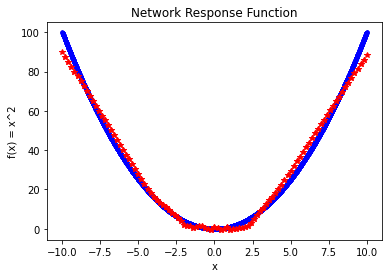

In [11]:
print("Note\n  The blue line is the true values of the funciton that the NN has learned to approximate.")
print("  The red line is the function learned.")
print("  Deviations between the blue and red line are errors in the modeling")

plt.plot(testdata, true_value, 'b.')
plt.ylabel('f(x) = x^2')
plt.xlabel('x')
plt.title('Test data')
plt.plot(input_value, prediction_value, 'r*')
plt.ylabel('f(x) = x^2')
plt.xlabel('x')
plt.title('Network Response Function')
plt.savefig("ann_model2.pdf")
print("See ann_model2.pdf for the plot")

The loss vs epoch is plotted below, where the blue is train data, and red test data
See ann_loss.pdf for the plot


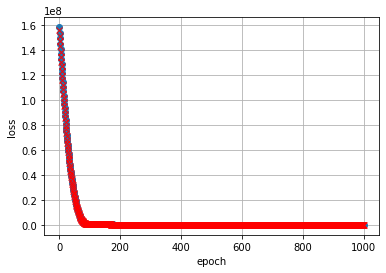

In [12]:
print("The loss vs epoch is plotted below, where the blue is train data, and red test data")

# for log plots comment out the following
plt.plot(epoch_set, loss_set, 'o', label='MLP Training phase')
plt.plot(epoch_set, loss_test_value, 'rx', label='MLP Training phase')
# For log plots uncomment the following
#plt.semilogy(epoch_set, loss_set, 'o', label='MLP Training phase')
#plt.semilogy(epoch_set, loss_test_value, 'rx', label='MLP Training phase')
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig("ann_loss2.pdf")
print("See ann_loss2.pdf for the plot")

The difference between the loss function value for the test and train data is used
as a measure of the training.  If the train data diverges signficiantly from the test
data loss function value then the network is overtrained
See ann_deltaloss2.pdf for the plot


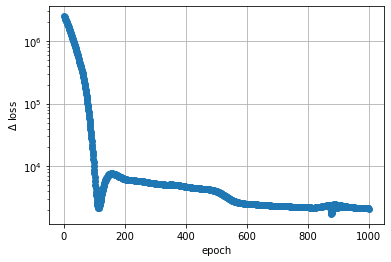

In [14]:
print("The difference between the loss function value for the test and train data is used")
print("as a measure of the training.  If the train data diverges signficiantly from the test")
print("data loss function value then the network is overtrained")

delta = np.subtract(loss_test_value, loss_set)
plt.semilogy(epoch_set, np.absolute(delta), 'o', label='MLP Training phase')
plt.grid(True)
plt.ylabel('$\Delta$ loss')
plt.xlabel('epoch')
plt.savefig("ann_deltaloss2.pdf")
print("See ann_deltaloss2.pdf for the plot")

Now that you have run through the FunctionApproximation2 notebook you may wish to adapt your network to use different activation functions, train for more epochs or to add more hidden layers.  These are just a few sugggestions to allow you to explore and adapt the code.